# 数据预处理

### 打开文件

In [1]:
import lxml.etree
import zipfile

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
labels = doc.xpath('//keywords/text()')

In [2]:
len(input_text)

2085

### 标签处理

根据作业要求，我们只抽取包含Technology，Entertainment和Design的文本

In [3]:
# 关键字抽取模块
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
valid_list = ['technology', 'entertainment', 'design']
for word in valid_list:
    keyword_processor.add_keyword(word)

In [4]:
labels[0:10]

['talks, business, creativity, curiosity, goal-setting, innovation, motivation, potential, success, work',
 'talks, Planets, TEDx, bacteria, biology, engineering, environment, evolution, exploration, future, innovation, intelligence, microbiology, nature, potential, science',
 'talks, Debate, Guns, activism, big problems, children, choice, community, future, goal-setting, government, law, leadership, marketing, parenting, policy, social change, violence',
 'talks, Brazil, Slavery, art, beauty, community, creativity, culture, design, global issues, humanity, identity, photography, race, social change, society, visualizations',
 'talks, NASA, communication, computers, creativity, design, engineering, exploration, future, innovation, interface design, invention, microsoft, potential, prediction, product design, technology, visualizations',
 'talks, Africa, Internet, community, democracy, development, future, government, identity, leadership, politics, potential',
 'talks, ancient world, a

In [4]:
def label_extrat(labels, valid_list):
    extract_words = [keyword_processor.extract_keywords(item) for item in labels]
    res = []
    for item in extract_words:
        if len(item) == 3:
            res.append('TED')
        elif len(item) == 2:
            if 'technology' in item:
                if 'entertainment' in item:
                    res.append('TEo')
                elif 'design' in item:
                    res.append('ToD')
            else:
                res.append('oED')
        elif len(item) == 1:
            if item[0] == 'technology':
                res.append('Too')
            elif item[0] == 'entertainment':
                res.append('oEo')
            elif item[0] == 'design':
                res.append('ooD')
        else:
            res.append('ooo')
    return res

In [5]:
new_labels = label_extrat(labels, valid_list)

我们来看看具体每个标签的数量

In [6]:
from collections import Counter
label_cnt = Counter()
for item in new_labels:
    label_cnt[item] += 1

In [7]:
label_cnt

Counter({'TED': 55,
         'TEo': 36,
         'ToD': 122,
         'Too': 381,
         'oED': 38,
         'oEo': 173,
         'ooD': 147,
         'ooo': 1133})

### 文本处理

有的文本出现了类似“(Video) Hyowon Gweon: See this? ”的文本，我们需要去除括号内的内容和说话人的名字

In [8]:
# 快速清理文本利器，正则表达式！
import re

In [9]:
def text_preprocess(text):
    res = []
    for item in text:
        item = re.sub(r'\([^)]*\)', '', item) #去除括号内的内容
        # 去除说话人的名字
        sentences = []
        for line in item.split('\n'):
            m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
            sentences.extend(sent for sent in re.split('\.|!|\?', m.groupdict()['postcolon']) if sent)
        item = '.'.join(sentences)
        item = re.sub(r'[^a-z0-9]+', ' ', item.lower()) #只保留小写字母和数字
        res.append(item.split())
    return res

我们想要保留句号等表示句子结束的符号，来作为词向量训练的语料

In [10]:
def embedding_text_process(text):
    res = []
    for item in text:
        # 去除说话人的名字
        sentences = []
        for line in item.split('\n'):
            m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
            sentences.extend(sent for sent in re.split('\.|!|\?', m.groupdict()['postcolon']) if sent)
        item = '.'.join(sentences)
        item = re.sub(r'\([^)]*\)', '', item) #去除括号内的内容
        item = re.sub(' \.{3,} ', ' ', item) #去除省略号
        item = re.split('\.|!|\?',item) #以句号、感叹号和问号作为断句点
        item = [row.strip() for row in item if row] #去除多余的空格和空行
        item = [re.sub(r'[^a-z0-9]+', ' ', row.lower()).split() for row in item]  #只保留小写字母和数字
        for row in item:
            if row != []:
                res.append(row)
    return res

In [11]:
sentences = embedding_text_process(input_text)
sentences[0]

['here',
 'are',
 'two',
 'reasons',
 'companies',
 'fail',
 'they',
 'only',
 'do',
 'more',
 'of',
 'the',
 'same',
 'or',
 'they',
 'only',
 'do',
 'what',
 's',
 'new']

In [12]:
new_text = text_preprocess(input_text)
new_text[0]

['here',
 'are',
 'two',
 'reasons',
 'companies',
 'fail',
 'they',
 'only',
 'do',
 'more',
 'of',
 'the',
 'same',
 'or',
 'they',
 'only',
 'do',
 'what',
 's',
 'new',
 'to',
 'me',
 'the',
 'real',
 'real',
 'solution',
 'to',
 'quality',
 'growth',
 'is',
 'figuring',
 'out',
 'the',
 'balance',
 'between',
 'two',
 'activities',
 'exploration',
 'and',
 'exploitation',
 'both',
 'are',
 'necessary',
 'but',
 'it',
 'can',
 'be',
 'too',
 'much',
 'of',
 'a',
 'good',
 'thing',
 'consider',
 'facit',
 'i',
 'm',
 'actually',
 'old',
 'enough',
 'to',
 'remember',
 'them',
 'facit',
 'was',
 'a',
 'fantastic',
 'company',
 'they',
 'were',
 'born',
 'deep',
 'in',
 'the',
 'swedish',
 'forest',
 'and',
 'they',
 'made',
 'the',
 'best',
 'mechanical',
 'calculators',
 'in',
 'the',
 'world',
 'everybody',
 'used',
 'them',
 'and',
 'what',
 'did',
 'facit',
 'do',
 'when',
 'the',
 'electronic',
 'calculator',
 'came',
 'along',
 'they',
 'continued',
 'doing',
 'exactly',
 'the'

文档的长度直方图

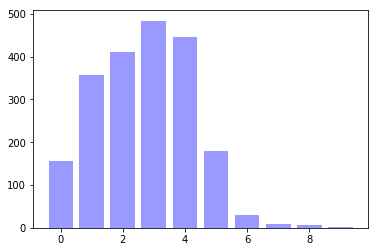

In [15]:
import matplotlib.pyplot as plt
import numpy as np
len_doc = [len(x) for x in new_text]
Y_plot, X_plot = np.histogram(len_doc, bins=10)
X_plot = np.arange(10)
plt.bar(X_plot, Y_plot, facecolor='#9999ff', edgecolor='white')
plt.show()

# 词向量训练

这里会使用三种词向量，分别是：
* 使用当前语料自己训练一个词向量
* 使用glove词向量：基于词共现矩阵训练的词向量 https://nlp.stanford.edu/projects/glove/
* 使用fastext词向量：基于预测方法训练的词向量，word2vec的改进版 https://fasttext.cc/

软件包版本：
* Gensim 3.2
* mxnet-cu90 1.0.1 master

通过mxnet的text API轻松调用glove和fasttext的预训练词向量

更新mxnet到master版本：pip install mxnet --pre --upgrade

In [13]:
from gensim.models import Word2Vec
from mxnet.contrib import text
from mxnet import gluon
from mxnet import nd
from mxnet.gluon import nn, rnn
import mxnet as mx
import numpy as np

D:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Gensim

In [14]:
# 使用gensim训练词向量
def word2vec(text, fname, ndims, window_size, min_cnt = 1):
    model = Word2Vec(text, min_count = min_cnt, window = window_size, size = ndims)
    word_vectors = model.wv
    word_vectors.save_word2vec_format(fname, binary = False)
    return model

# 从本地文件加载词向量
def load_embeddings(fname):
    embeddings_index = {}
    f = open(fname, encoding = 'utf-8')
    for k,line in enumerate(f.readlines()):
        if k != 0:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [18]:
#w2v_model = word2vec(sentences, 'gensim_w2v_300d.txt', 300, 5, 5)
w2v_embeddings = load_embeddings('gensim_w2v_300d.txt')

In [19]:
len(w2v_embeddings)

21448

### mxnet Text API

In [15]:
# 目前只能从字符串文本中构建词向量
def text_process_str(text):
    res = []
    for item in text:
        item = re.sub(r'\([^)]*\)', '', item) #去除括号内的内容
        # 去除说话人的名字
        sentences = []
        for line in item.split('\n'):
            m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
            sentences.extend(sent for sent in re.split('\.|!|\?', m.groupdict()['postcolon']) if sent)
        item = '.'.join(sentences)
        item = re.sub(r'[^a-z0-9]+', ' ', item.lower()) #只保留小写字母和数字
        res.append(item)
    final_res = '\n'.join(res)
    return final_res

text_str = text_process_str(input_text)

<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence 

In [16]:
counter = text.utils.count_tokens_from_str(text_str)
my_vocab = text.vocab.Vocabulary(counter, most_freq_count=21448, unknown_token='<UNK>')

In [17]:
fasttext_embedding = text.embedding.create('fasttext', pretrained_file_name='wiki.simple.vec', vocabulary=my_vocab)
glove_embedding = text.embedding.create('glove', pretrained_file_name='glove.6B.300d.txt', vocabulary=my_vocab)

D:\Anaconda3\lib\site-packages\mxnet\contrib\text\embedding.py:278: UserWarning: At line 1 of the pre-trained text embedding file: token 111051 with 1-dimensional vector [300.0] is likely a header and is skipped.
  'skipped.' % (line_num, token, elems))


计算词向量相似度

In [18]:
def norm_vecs_by_row(x):
    return x / nd.sqrt(nd.sum(x * x, axis=1)).reshape((-1,1))

def get_knn(token_embedding, k, word):
    word_vec = token_embedding.get_vecs_by_tokens([word]).reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(token_embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs, word_vec)
    indices = nd.topk(dot_prod.reshape((len(token_embedding), )), k=k+2,
                      ret_typ='indices')
    indices = [int(i.asscalar()) for i in indices]
    # 除去未知词符号和输入词。
    return token_embedding.to_tokens(indices[2:])

我们可以看到glove和fasttext基于更大的的语料训练得到的词的相似性更加准确

In [24]:
w2v_model.wv.most_similar('apple')

NameError: name 'w2v_model' is not defined

In [19]:
get_knn(glove_embedding, 5, 'apple')

['iphone', 'ipod', 'microsoft', 'ipad', 'intel']

In [20]:
get_knn(fasttext_embedding, 5, 'apple')

['apples', 'app', 'iphone', 'ipod', 'ipad']

# 模型初始化

接下来将从简单的模型开始，模型依次为：
* 单层感知机
* LSTM
* GRU

In [21]:
from mxnet.gluon import nn, rnn

RNN模型初始化定义，包含四个模型，分别是：
* rnn_relu
* rnn_tanh
* rnn_sigmoid
* lstm
* gru
* bi-gru

In [22]:
class RNNModel(gluon.Block):
    """循环神经网络模型库"""
    def __init__(self, mode, embed_matrix, vocab_size, embed_dim, hidden_dim,
                 num_layers, num_labels, dropout=0.5, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            self.drop = nn.Dropout(dropout)
            if embed_matrix:
                self.encoder = nn.Embedding(vocab_size, embed_dim)
                #self.encoder.initialize()
                self.encoder.weight.set_data(embed_matrix.idx_to_vec)
            else:
                self.encoder = nn.Embedding(vocab_size, embed_dim)
            
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(hidden_dim, num_layers, activation='relu',
                                   dropout=dropout, input_size=embed_dim)
            elif mode == 'rnn_sigmoid':
                self.rnn = rnn.RNN(hidden_dim, num_layers, activation='sigmoid',
                                   dropout=dropout, input_size=embed_dim)    
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(hidden_dim, num_layers, dropout=dropout,
                                   input_size=embed_dim)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(hidden_dim, num_layers, dropout=dropout,
                                    input_size=embed_dim)
            elif mode == 'gru':
                self.rnn = rnn.GRU(hidden_dim, num_layers, dropout=dropout,
                                   input_size=embed_dim)
            elif mode == 'bi-gru':
                self.rnn = rnn.GRU(hidden_dim, num_layers, dropout=dropout,
                                   bidirectional=True, input_size=embed_dim)
            else:
                raise ValueError("Invalid mode %s. Options are rnn_relu, "
                                 "rnn_tanh, lstm, and gru"%mode)

            self.decoder = nn.Dense(num_labels, in_units=hidden_dim, 
                                    activation='softmax')
            self.hidden_dim = hidden_dim
            
    def forward(self, inputs, state):
        emb = self.encoder(inputs)
        output, state = self.rnn(emb, state)
        output = self.drop(output)
        decoded = self.decoder(output.reshape((-1, self.hidden_dim)))
        return decoded, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

模型超参数

In [23]:
model_name = 'bi-gru'

embed_dim = 300 # 词向量维度
hidden_dim = 100 # RNN隐藏层大小
num_layers = 2 # RNN隐藏层层数
lr = 0.001 # 初始学习率
lr_decay = 80 # 每xxx步学习率下降
clipping_norm = 0.2 # 梯度裁剪大小
epochs = 10 # 迭代轮数
batch_size = 64 # 批量大小

dropout_rate = 0.5 # 丢弃率
eval_period = 100 # 验证步数
num_labels = len(label_cnt) # 标签个数

# 数据集构建

词汇表

In [24]:
vocab = my_vocab.token_to_idx
idx2vocab = {v:k for k,v in vocab.items()}
vocab_size = len(vocab)

In [25]:
vocab

{'<UNK>': 0,
 'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 'that': 6,
 'i': 7,
 'in': 8,
 'it': 9,
 'you': 10,
 'we': 11,
 'is': 12,
 's': 13,
 'this': 14,
 'so': 15,
 'they': 16,
 'was': 17,
 'for': 18,
 'are': 19,
 'have': 20,
 'but': 21,
 'what': 22,
 'on': 23,
 'with': 24,
 'can': 25,
 't': 26,
 'about': 27,
 'there': 28,
 'be': 29,
 'as': 30,
 'at': 31,
 'all': 32,
 'not': 33,
 'do': 34,
 'my': 35,
 'one': 36,
 're': 37,
 'people': 38,
 'like': 39,
 'if': 40,
 'from': 41,
 'now': 42,
 'our': 43,
 'he': 44,
 'an': 45,
 'just': 46,
 'these': 47,
 'or': 48,
 'when': 49,
 'because': 50,
 'very': 51,
 'me': 52,
 'out': 53,
 'by': 54,
 'them': 55,
 'how': 56,
 'know': 57,
 'up': 58,
 'going': 59,
 'had': 60,
 'more': 61,
 'think': 62,
 'who': 63,
 'were': 64,
 'see': 65,
 'your': 66,
 'their': 67,
 'which': 68,
 'would': 69,
 'here': 70,
 'really': 71,
 'get': 72,
 've': 73,
 'then': 74,
 'm': 75,
 'world': 76,
 'us': 77,
 'time': 78,
 'some': 79,
 'has': 80,
 'don': 81,
 'actuall

词向量矩阵

In [31]:
def build_embeddings(embed_index, vocab, n_dim):
    """根据词汇表获取embedding中的词向量"""
    embedding_matrix = nd.zeros((len(vocab), n_dim))
    for word, i in vocab.items():
        try:
            embedding_matrix[i] = embed_index.get_vecs_by_tokens(word)
        except:
            pass
    return embedding_matrix

embed_matrix = build_embeddings(fasttext_embedding, vocab, 300)
embed_matrix.shape

(21449, 300)

获得固定长度的文本序列及将词替换为index

In [32]:
from sklearn import preprocessing

def pad_sentences(sentences, padding_word="<UNK>"):
    """
    将文本处理为固定长度，长度为最长文档的长度
    """
    sequence_length = int(0.8 * max(len(x) for x in sentences))
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        if len(sentence) >= sequence_length:
            new_sentence = sentence[0:sequence_length]
        else:
            num_padding = sequence_length - len(sentence)
            new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

def build_input_data(sentences, labels, vocabulary):
    """
    基于词典映射句子和标签
    """
    x = np.array([[vocabulary[word] if word in vocabulary else 0 for word in sentence] for sentence in sentences])
    y = np.zeros(shape=(len(labels), 8))
    le = preprocessing.LabelEncoder() 
    labels = le.fit_transform(new_labels)
    for i,label in enumerate(labels):
        y[i][label] = 1
    return [x, y]

In [34]:
sentences_padded = pad_sentences(new_text)
x, y = build_input_data(sentences_padded, labels, vocab)
print(x[0][0:10])
print(y[0])
print(x.shape)

[  70   19  103  790  553 2037   16  119   34   61]
[ 0.  0.  0.  0.  0.  0.  0.  1.]
(2085, 5348)


切分训练/验证/测试集

In [35]:
# 随机打乱数据
np.random.seed(2018)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

x_train, x_dev = x_shuffled[:-500], x_shuffled[-500:]
y_train, y_dev = y_shuffled[:-500], y_shuffled[-500:]
x_dev, x_test = x_dev[:-250], x_dev[-250:]
y_dev, y_test = y_dev[:-250], y_dev[-250:]
sentence_size = x_train.shape[1]
                              
print('训练集/验证集比例: %d/%d' % (len(y_train), len(y_dev)))
print('训练集大小:', x_train.shape)
print('验证集大小:', x_dev.shape)
print('词汇量', vocab_size)
print('最长的文档字数', sentence_size)

训练集/验证集比例: 1585/250
训练集大小: (1585, 5348)
验证集大小: (250, 5348)
词汇量 21449
最长的文档字数 5348


In [42]:
def batchify(data, batch_size):
    """数据形状 (num_batches, batch_size)"""
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]
    data = data.reshape((batch_size, num_batches)).T
    return data

data = batchify(x_train, batch_size)
data.shape

ValueError: cannot reshape array of size 8214528 into shape (64,24)

# 模型训练

In [36]:
def try_gpu():
    """如果gpu可用, 使用第一个gpu设备; 否则使用CPU"""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx
context = try_gpu()

构建模型，定义损失函数

In [37]:
model_fast = RNNModel(model_name, fasttext_embedding, vocab_size, 
                      embed_dim, hidden_dim, num_layers, num_labels, dropout_rate)
model_fast.collect_params().initialize(mx.init.Xavier(), ctx=context) # xavier权重值初始化
trainer = gluon.Trainer(model_fast.collect_params(), 
                        'adam', {'learning_rate': lr}) # adam优化器
loss = gluon.loss.SoftmaxCrossEntropyLoss() # 交叉熵loss

模型大致结构

In [38]:
model_fast.name_scope

<bound method Block.name_scope of RNNModel(
  (drop): Dropout(p = 0.5)
  (encoder): Embedding(21449 -> 300, float32)
  (rnn): GRU(300 -> 300, TNC, num_layers=2, dropout=0.5, bidirectional)
  (decoder): Dense(100 -> 8, Activation(softmax))
)>

In [40]:
isinstance(context, mx.Context)

True

训练函数

In [39]:
import time

def train(model, context):
    print("Start training on ", context)
    for epoch in range(epochs):
        train_loss, train_acc, n, m = 0.0, 0.0, 0.0, 0.0
        start_time = time.time()
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = batch_size,
                                   ctx = context)
        for begin in enumerate(range(0, x_train.shape[0], batch_size)):
            batchX = x_train[begin:begin+batch_size]
            batchY = y_train[begin:begin+batch_size]
            if epoch > 0 and epoch % lr_period == 0:
                trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            with autograd.record():
                output, hidden = model(data, hidden)
                L = loss(output, target)
                L.backward()

            grads = [i.grad(context) for i in model.collect_params().values()]
            # 梯度裁剪。需要注意的是，这里的梯度是整个批量的梯度。
            # 因此我们将clipping_norm乘以num_steps和batch_size。
            gluon.utils.clip_global_norm(grads,
                                         clipping_norm * num_steps * batch_size)

            trainer.step(batch_size)
            total_L += mx.nd.sum(L).asscalar()

            if ibatch % eval_period == 0 and ibatch > 0:
                cur_L = total_L / num_steps / batch_size / eval_period
                print('[Epoch %d Batch %d] loss %.2f, perplexity %.2f' % (
                    epoch + 1, ibatch, cur_L, math.exp(cur_L)))
                total_L = 0.0

        val_L = model_eval(val_data)

        print('[Epoch %d] time cost %.2fs, validation loss %.2f, validation '
              'perplexity %.2f' % (epoch + 1, time.time() - start_time, val_L,
                                   math.exp(val_L)))

# 问题

1. 比较使用不同词向量的模型的学习曲线，随机词向量，变化的glove词向量和不变的glove词向量，哪一个模型在测试集上表现最好？哪个模型的准确率最高？

2. 如果我们将tanh换成sigmoid或者relu等非线性函数，结果会怎样？

3. 如果你加入dropout层，结果会怎样？

4. 如果你改变隐藏层大小，结果会怎样？

5. 如果你想再加入一层隐藏层，代码应作何修改？

6. 训练算法对模型的质量的影响程度？

7. 如果我们队标签映射为2维的向量并可视化，会有什么有趣的情况发生？

# 额外部分：多标签分类